#**LÓGICA PARA EL ENTRENAMIENTO DEL MODELO**

In [ ]:
# CONFIGURACIÓN INICIAL
google_drive_folder = # Ruta a la carpeta que contiene los datos de imagen y máscara.
image_mask_pairs = load_images_masks(google_drive_folder) # Carga los pares de imagen y máscara desde la carpeta especificada.

print(f"Total de pares disponibles: {len(image_mask_pairs)}")

##########################################################################################################
# n_iter: ES EL PARAMETRO QUE ESTABLECE EL NUMERO DE PASADAS ESTOCASTICAS QUE SE REALIZA DURANTE EL
#         ENTRENAMIENTO DE LA RED Y SU CONFIGURACIÓN ESTANDAR ES "n_iter=1", LO QUE HACE QUE EL
#         MODELO SEA DETERMINISTA, AUMENTAR EL VALOR DE n_iter HACE QUE SE APLIQUE MONTE CARLO DROPOUT
##########################################################################################################

n_iter = 15 # Establece el número de iteraciones para el dropout de Monte Carlo durante el análisis de incertidumbre.
n_images_to_display = 6 # Define el número de imágenes para mostrar durante la fase de evaluación.
fold = 1 # Inicializa el contador de folds.
histories = [] # Crea una lista vacía para almacenar el historial de entrenamiento para cada fold.
test_data_pairs = [] # Crea una lista vacía para almacenar los pares de datos de prueba para cada fold.

pretrained_weights_path = "sin_pesos"
input_shape = (192, 192, 192, 1)

# BUCLE DE VALIDACIÓN CRUZADA K-FOLD:
for train_index, test_index in kf.split(image_mask_pairs):# El código itera a través de cada fold usando kf.split(image_mask_pairs)
    print(f"\n--- Entrenando el pliegue {fold} de K-Fold ---")

    train_pairs = [image_mask_pairs[i] for i in train_index] # Divide los datos en conjuntos de entrenamiento y prueba para el fold actual.
    test_pairs  = [image_mask_pairs[i] for i in test_index] # Divide los datos en conjuntos de entrenamiento y validación.

    test_data_pairs.append(test_pairs) # Agrega los pares de validación a una lista para su uso posterior.

    # Dataset de entrenamiento con augment=True
    ds_train = create_dataset(train_pairs, augment=True, batch_size=1) # Crea un conjunto de datos de TensorFlow para los datos de entrenamiento con aumentos habilitados.
    # Dataset de validación/test sin augment
    ds_val   = create_dataset(test_pairs,  augment=False, batch_size=1) # Crea un conjunto de datos de TensorFlow para los datos de validación sin aumentos.

    print(f"[INFO] -> Pliegue {fold}: "
          f"{len(train_pairs)} muestras de entrenamiento, "
          f"{len(test_pairs)} muestras de validación/test.")

    # ENTRENAMIENTO DEL MODELO
    # Instanciar modelo
    model = unet_3d_version10(input_shape)
    # Carga de pesos preentrenados si existen
    if os.path.exists(pretrained_weights_path):
        model.load_weights(pretrained_weights_path)
        print("Pesos preentrenados cargados correctamente.")
    else:
        print("Entrenando desde cero (sin pesos preentrenados).")

    # Establece la métrica a monitorear durante el entrenamiento (en este caso, el Dice en el conjunto de validación).
    monitor_metric = 'val_dice_metric'  # Actualizar si tu log es 'val_dice_metric'
    # Define un callback para guardar el mejor modelo durante el entrenamiento, basándose en la métrica monitoreada.
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'best_model_fold_{fold}.keras',
        monitor=monitor_metric,
        verbose=1,
        save_best_only=True,
        mode='max'
    )
    # Define un callback para detener el entrenamiento temprano si la métrica monitoreada no mejora durante un número específico de épocas.
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor=monitor_metric,
        patience=10,
        restore_best_weights=True,
        mode='max'
    )
    # Define un callback para reducir la tasa de aprendizaje durante el entrenamiento si la métrica monitoreada se estanca.
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor=monitor_metric,
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1,
        mode='max'
    )
    # Entrena el modelo utilizando los conjuntos de datos de entrenamiento y validación y los callbacks definidos.
    epochs_to_train = 50
    print(f"[INFO] -> Entrenando por {epochs_to_train} épocas ...")
    history = model.fit(
        ds_train,
        epochs=epochs_to_train,
        validation_data=ds_val,
        callbacks=[checkpoint, early_stop, reduce_lr]
    )
    # Guarda los pesos entrenados para el fold actual.
    histories.append(history)
    model.save_weights(f'weights_fold_{fold}.weights.h5')

    # EVALUACIÓN DEL MODELO
    # Evalúa el modelo entrenado en el conjunto de datos de validación (ds_val) e imprime los resultados.
    #ds_val representa el conjunto de validación en el contexto de la validación cruzada.
    test_loss, test_dice_metric, test_iou_score, test_precision, test_recall = model.evaluate(ds_val)
    print(f"[RESULTADOS fold {fold}] -> "
    f"Loss: {test_loss:.4f} - F1: {test_dice_metric:.4f} - IOU: {test_iou_score:.4f} - "
    f"Precision: {test_precision:.4f} - Recall: {test_recall:.4f}")

    # ANÁLISIS DE INCERTIDUMBRE
    # El conjunto de datos de validación ds_val se convierte a arrays de NumPy para facilitar su manipulación.
    test_images_list = []
    test_masks_list  = []
    for img_b, msk_b in ds_val:
        test_images_list.extend(img_b.numpy())
        test_masks_list.extend(msk_b.numpy())
    test_images = np.array(test_images_list, dtype=np.float32)
    test_masks  = np.array(test_masks_list, dtype=np.float32)
    print(f"[INFO] -> MC-Dropout con n_iter={n_iter} en {len(test_images)} volúmenes ...")
    # Realiza dropout de Monte Carlo para estimar la incertidumbre de las predicciones del modelo en los datos de validación.
    mean_pred_masks, var_pred_masks, all_preds = predict_with_uncertainty(model, test_images, n_iter=n_iter, batch_size=1)
    mean_pred_masks_bin = (mean_pred_masks > 0.5).astype(np.float32)

    # DICE / FScore -> Calcula el coeficiente de Dice utilizando las máscaras predichas promedio.
    test_dice_mc = dice_metric(tf.constant(test_masks), tf.constant(mean_pred_masks_bin)).numpy()
    # test_masks aquí se refiere a las máscaras reales del conjunto de validación.
    # mean_pred_masks_bin se refiere a las máscaras predichas promedio binarizadas (aplicando el umbral)
    print(f"[MC-DROPOUT] -> Dice medio: {test_dice_mc:.4f}")

    # VISUALIZACIÓN: El código genera gráficos de la pérdida de entrenamiento y validación y el coeficiente de Dice para cada fold.
    if n_iter > 1:
        dice_scores = []
        for p in all_preds:
            p_bin = (p > 0.5).astype(np.float32)
            d_val = dice_metric(tf.constant(test_masks), tf.constant(p_bin)).numpy()
            dice_scores.append(d_val)
        plt.figure(figsize=(10,5))
        plt.bar(range(1, n_iter+1), dice_scores, color='blue')
        plt.xlabel("Iter MC-Dropout")
        plt.ylabel("Dice Coefficient")
        plt.title("Consistencia MC-Dropout")
        plt.show()
    # Visualizar algunas predicciones
    n_images_to_display_fold = min(n_images_to_display, len(test_images))
    indices_to_display = np.random.choice(len(test_images), n_images_to_display_fold, replace=False)

    for idx in indices_to_display:
        mostrar_prediccion_error(
            imagen=test_images[idx],
            mascara_real=test_masks[idx],
            mascara_predicha_media=mean_pred_masks_bin[idx],
            varianza_predicha=var_pred_masks[idx],
            slice_index=100)
    # Gráficas de entrenamiento
    plt.figure(figsize=(12, 4))
    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title(f'Fold {fold} - Pérdida')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # Fscore (o dice_metric)
    plt.subplot(1, 2, 2)
    if 'fscore' in history.history:
        plt.plot(history.history['fscore'], label='Entrenamiento')
        plt.plot(history.history['val_fscore'], label='Validación')
        plt.title(f'Fold {fold} - Fscore')
    else:
        plt.plot(history.history['dice_metric'], label='Entrenamiento')
        plt.plot(history.history['val_dice_metric'], label='Validación')
        plt.title(f'Fold {fold} - Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Fscore/Dice')
    plt.legend()

    plt.show()

    fold += 1 # INCREMENTA LA CUENTA DEL FOLD PARA SEGUIR CON EL SIGUIENTE

print("\n[FIN ENTRENAMIENTO K-FOLD] - Se guardaron historiales en 'histories'.")


#**EJEMPLO INFERENCIA EN IMAGENES DE TESTING - ISBI 2015**

Procesando: /content/drive/My Drive/TESTING_UNET/test_ISBI_2015/test01/preprocessed/test01_01_flair_pp_padded.nii


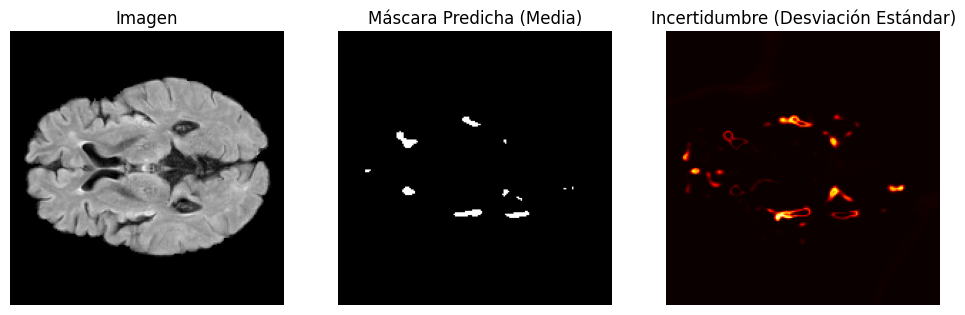

  Resultados guardados en: /content/drive/My Drive/test_ISBI_2015_predictions
Procesando: /content/drive/My Drive/TESTING_UNET/test_ISBI_2015/test01/preprocessed/test01_03_flair_pp_padded.nii


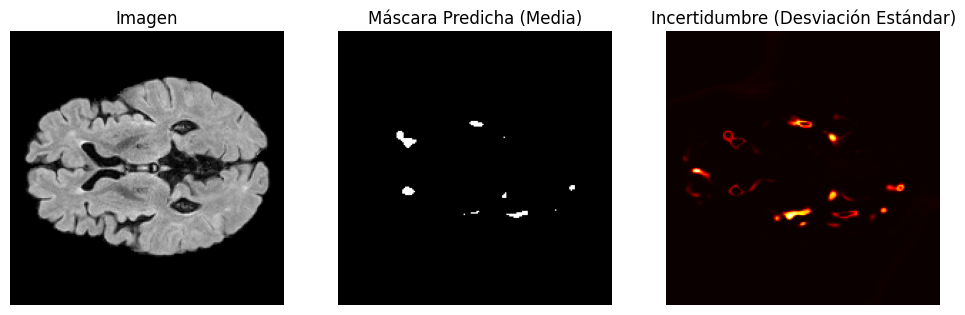

  Resultados guardados en: /content/drive/My Drive/test_ISBI_2015_predictions
Procesando: /content/drive/My Drive/TESTING_UNET/test_ISBI_2015/test01/preprocessed/test01_02_flair_pp_padded.nii


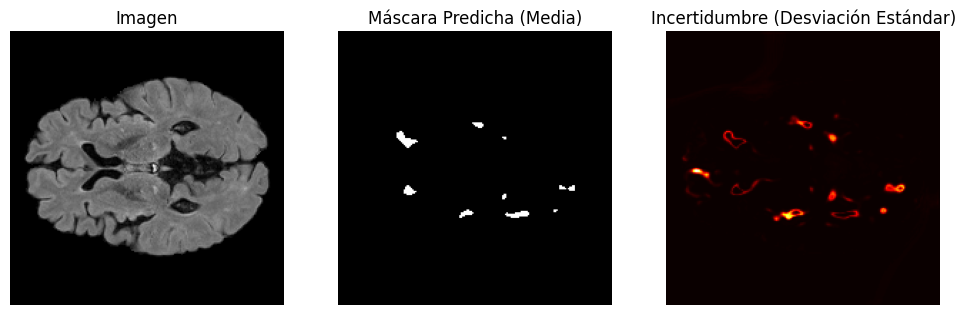

  Resultados guardados en: /content/drive/My Drive/test_ISBI_2015_predictions
Procesando: /content/drive/My Drive/TESTING_UNET/test_ISBI_2015/test01/preprocessed/test01_04_flair_pp_padded.nii


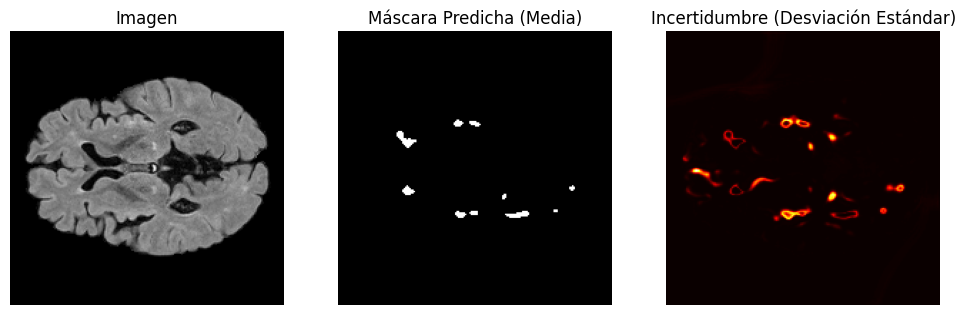

  Resultados guardados en: /content/drive/My Drive/test_ISBI_2015_predictions
Procesando: /content/drive/My Drive/TESTING_UNET/test_ISBI_2015/test02/preprocessed/test02_01_flair_pp_padded.nii


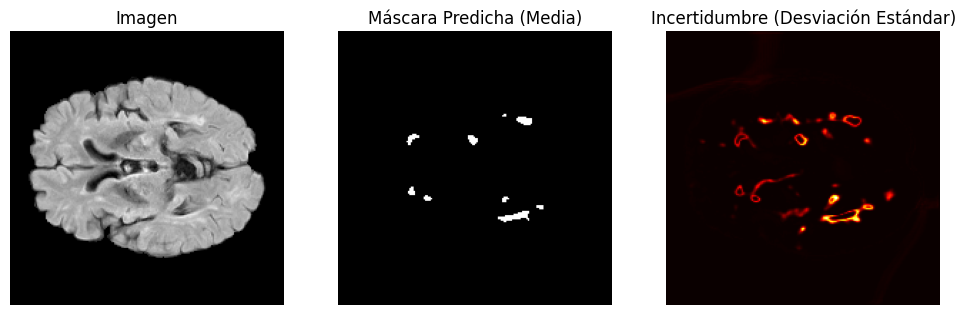

  Resultados guardados en: /content/drive/My Drive/test_ISBI_2015_predictions
Procesando: /content/drive/My Drive/TESTING_UNET/test_ISBI_2015/test02/preprocessed/test02_03_flair_pp_padded.nii


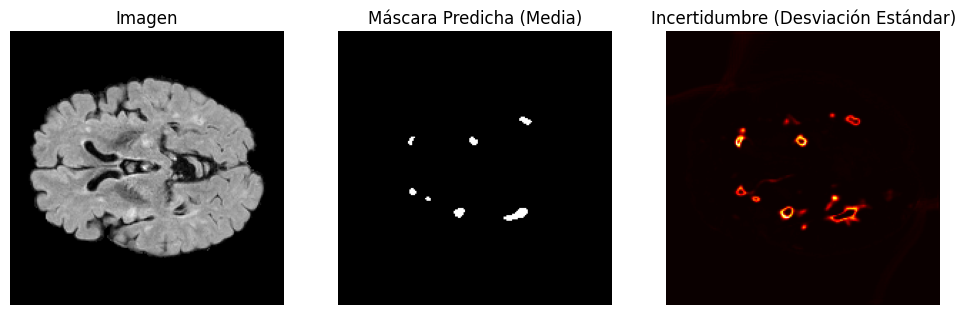

  Resultados guardados en: /content/drive/My Drive/test_ISBI_2015_predictions
Procesando: /content/drive/My Drive/TESTING_UNET/test_ISBI_2015/test02/preprocessed/test02_02_flair_pp_padded.nii


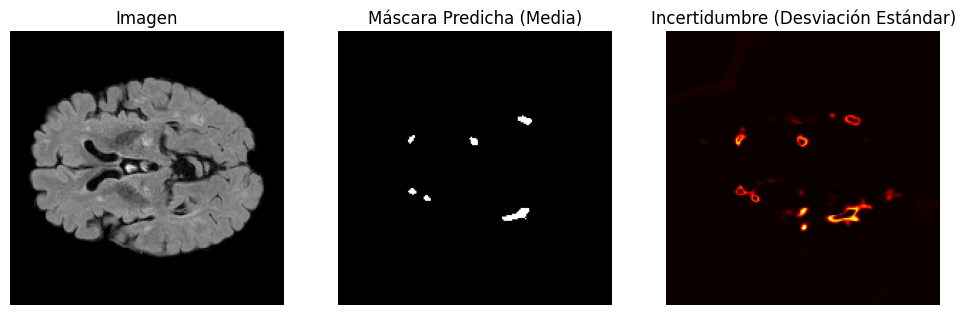

  Resultados guardados en: /content/drive/My Drive/test_ISBI_2015_predictions
Procesando: /content/drive/My Drive/TESTING_UNET/test_ISBI_2015/test02/preprocessed/test02_05_flair_pp_padded.nii


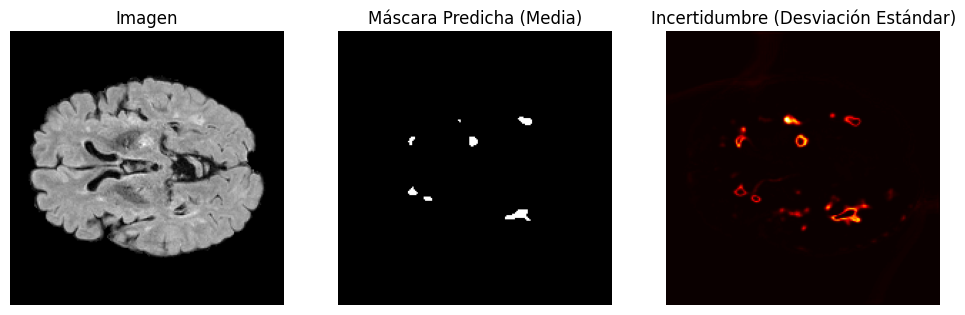

  Resultados guardados en: /content/drive/My Drive/test_ISBI_2015_predictions
Procesando: /content/drive/My Drive/TESTING_UNET/test_ISBI_2015/test02/preprocessed/test02_04_flair_pp_padded.nii


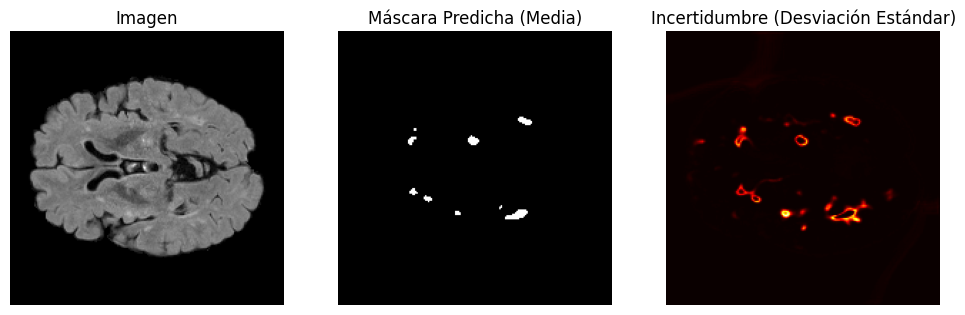

  Resultados guardados en: /content/drive/My Drive/test_ISBI_2015_predictions
Procesando: /content/drive/My Drive/TESTING_UNET/test_ISBI_2015/test03/preprocessed/test03_01_flair_pp_padded.nii


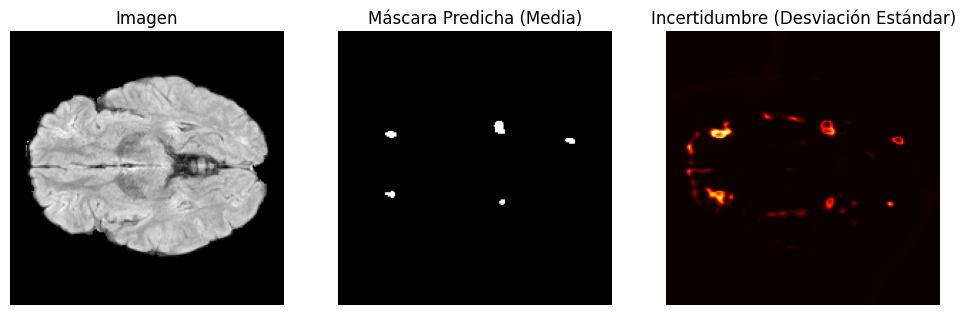

  Resultados guardados en: /content/drive/My Drive/test_ISBI_2015_predictions
Procesando: /content/drive/My Drive/TESTING_UNET/test_ISBI_2015/test03/preprocessed/test03_02_flair_pp_padded.nii


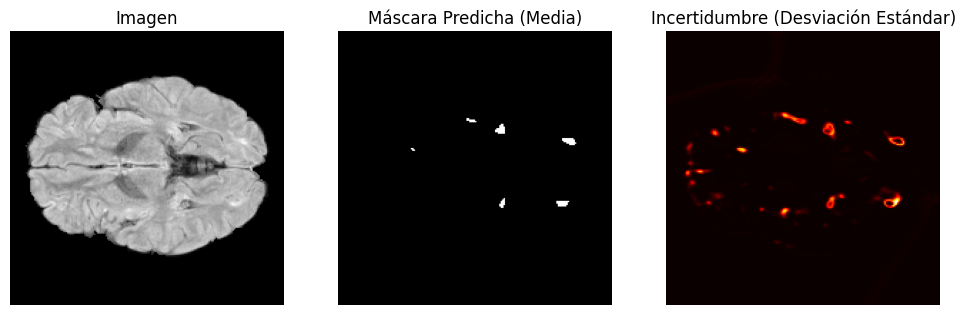

  Resultados guardados en: /content/drive/My Drive/test_ISBI_2015_predictions
Procesando: /content/drive/My Drive/TESTING_UNET/test_ISBI_2015/test03/preprocessed/test03_04_flair_pp_padded.nii


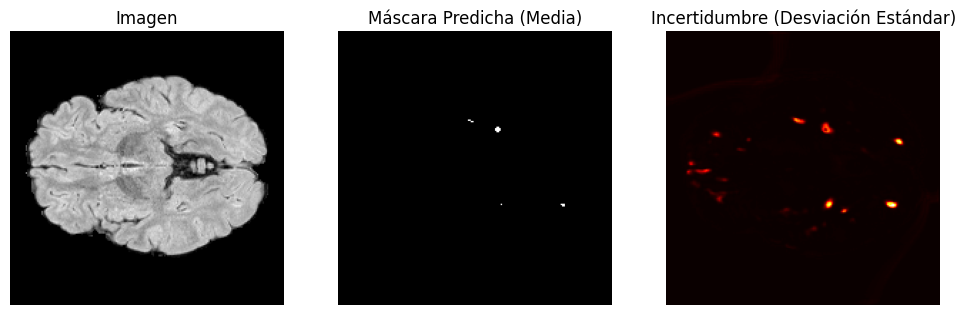

  Resultados guardados en: /content/drive/My Drive/test_ISBI_2015_predictions
Procesando: /content/drive/My Drive/TESTING_UNET/test_ISBI_2015/test03/preprocessed/test03_03_flair_pp_padded.nii


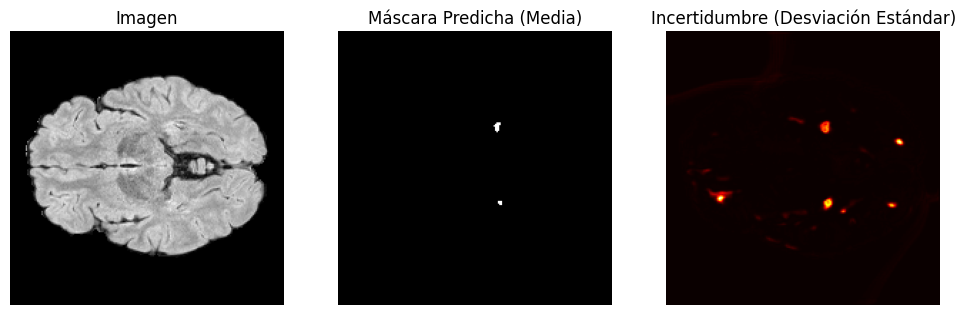

  Resultados guardados en: /content/drive/My Drive/test_ISBI_2015_predictions
Proceso completado.


In [ ]:
if __name__ == '__main__':

    # --- Configuraciones ---
    model_path = '/content/best_model_fold_3.keras'
    input_folder = '/content/drive/My Drive/TESTING_UNET/test_ISBI_2015'
    output_folder = '/content/drive/My Drive/test_ISBI_2015_predictions'
    n_iter_mc = 30
    slice_to_show = 90

    input_image_paths = glob.glob(os.path.join(input_folder, '*/preprocessed/*_flair_pp_padded.nii'), recursive=True)

    if not input_image_paths:
        print("ERROR.")
    else:
      # --- Inferencia ---
      inferencia_y_visualizacion(model_path, input_image_paths, output_folder, n_iter=n_iter_mc, slice_index=slice_to_show)
      print("Proceso completado.")

#**EJEMPLO INFERENCIA EN IMAGENES DE TESTING - MSSEG 2016**

Procesando: /content/drive/My Drive/TESTING_UNET/train_MSSEG2016_processed/Center_07/training02/preprocessed/test07_02_flair_pp_padded.nii


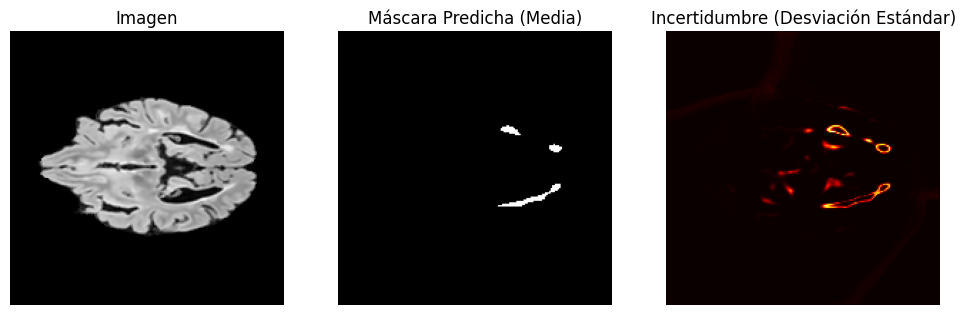

  Resultados guardados en: /content/drive/My Drive/train_MSSEG2016_predictions
Procesando: /content/drive/My Drive/TESTING_UNET/train_MSSEG2016_processed/Center_07/training01/preprocessed/test07_01_flair_pp_padded.nii


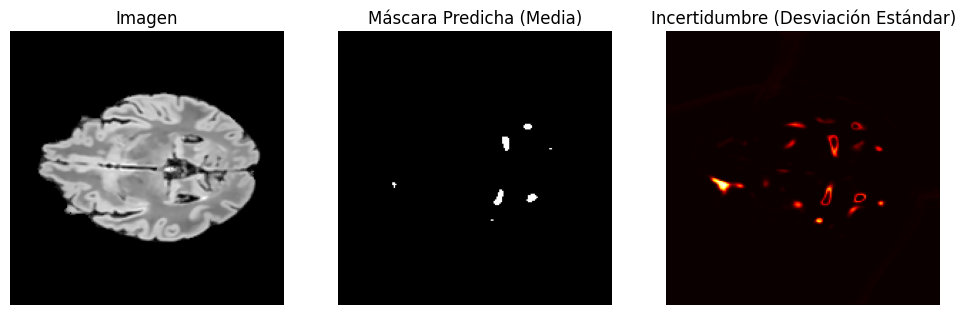

  Resultados guardados en: /content/drive/My Drive/train_MSSEG2016_predictions
Procesando: /content/drive/My Drive/TESTING_UNET/train_MSSEG2016_processed/Center_07/training05/preprocessed/test07_05_flair_pp_padded.nii


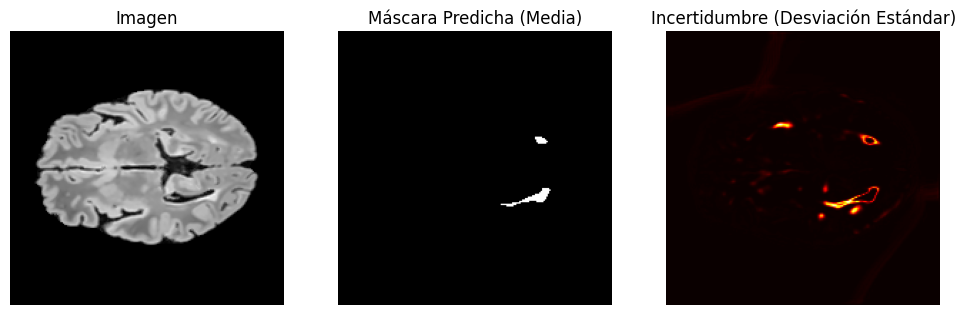

  Resultados guardados en: /content/drive/My Drive/train_MSSEG2016_predictions
Procesando: /content/drive/My Drive/TESTING_UNET/train_MSSEG2016_processed/Center_07/training04/preprocessed/test07_04_flair_pp_padded.nii


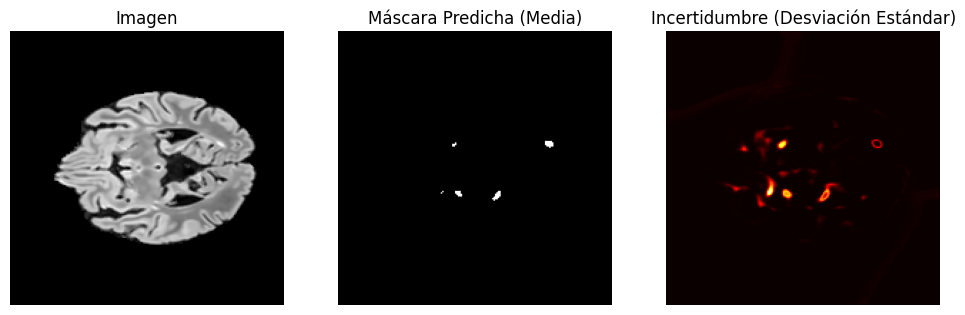

  Resultados guardados en: /content/drive/My Drive/train_MSSEG2016_predictions
Procesando: /content/drive/My Drive/TESTING_UNET/train_MSSEG2016_processed/Center_07/training03/preprocessed/test07_03_flair_pp_padded.nii


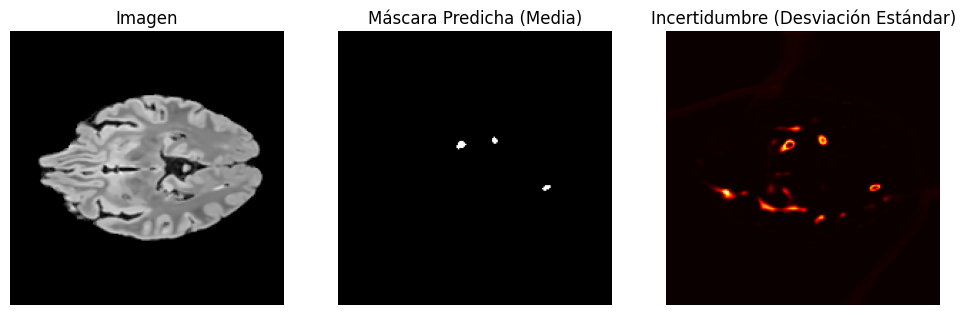

  Resultados guardados en: /content/drive/My Drive/train_MSSEG2016_predictions
Proceso completado.


In [ ]:
if __name__ == '__main__':

    # --- Configuraciones ---
    model_path = '/content/best_model_fold_3.keras'
    input_folder = '/content/drive/My Drive/TESTING_UNET/train_MSSEG2016_processed'
    output_folder = '/content/drive/My Drive/train_MSSEG2016_predictions'
    n_iter_mc = 30
    slice_to_show = 90

    input_image_paths = glob.glob(os.path.join(input_folder, 'Center_07/*/preprocessed/*_flair_pp_padded.nii'), recursive=True)


    if not input_image_paths:
        print("ERROR")
    else:
      # --- Inferencia ---
      inferencia_y_visualizacion(model_path, input_image_paths, output_folder, n_iter=n_iter_mc, slice_index=slice_to_show)
      print("Proceso completado.")